# Import Libraries


In [28]:
import pandas as pd
import numpy as np

#plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

#sklearn MSE
from sklearn.metrics import mean_squared_error 

from scipy import stats

#statsmodel
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels import graphics
from statsmodels.compat import lzip
from statsmodels.graphics.api import abline_plot
from statsmodels.genmod.generalized_linear_model import GLM

import pickle

# Import and Explore data

In [29]:
motor_insurance = pd.read_csv('SwedishMotorInsurance.csv',header=0)
motor_insurance

,Kilometres,Zone,Bonus,Make,Insured,Claims,Payment
0,1,1,1,1,455.13,108,392491
1,1,1,1,2,69.17,19,46221
2,1,1,1,3,72.88,13,15694
3,1,1,1,4,1292.39,124,422201
4,1,1,1,5,191.01,40,119373
...,...,...,...,...,...,...,...
2177,5,7,7,5,8.74,0,0
2178,5,7,7,6,16.61,0,0
2179,5,7,7,7,2.83,1,966
2180,5,7,7,8,13.06,0,0


In [30]:
motor_insurance['Insured'].describe()

count      2182.000000
mean       1092.195270
std        5661.156245
min           0.010000
25%          21.610000
50%          81.525000
75%         389.782500
max      127687.270000
Name: Insured, dtype: float64

In [31]:


#We can remove the rows where payment and claim are 0

motor_insurance = motor_insurance[(motor_insurance['Claims']!=0) & (motor_insurance['Payment']!=0)]

In [32]:
#getting the features info
#converting the dtype of categoricals

motor_insurance = motor_insurance.astype({"Kilometres":str,"Zone":str,"Bonus":str,"Make":str})
motor_insurance.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1797 entries, 0 to 2181
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Kilometres  1797 non-null   object 
 1   Zone        1797 non-null   object 
 2   Bonus       1797 non-null   object 
 3   Make        1797 non-null   object 
 4   Insured     1797 non-null   float64
 5   Claims      1797 non-null   int64  
 6   Payment     1797 non-null   int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 112.3+ KB


c:\users\harsh\anaconda3\envs\insurance\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Payment', ylabel='Density'>

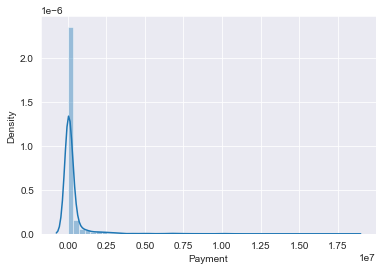

In [33]:
#histogram payment
sns.set_style('darkgrid')
sns.distplot(motor_insurance['Payment'])

## Feature Engineering

In [9]:
#PaymentPerClaim
motor_insurance['PaymentPerClaim'] =  motor_insurance['Payment'] / motor_insurance['Claims']

#PaymentPerInsured
motor_insurance['PaymentPerInsured'] =  motor_insurance['Payment'] / motor_insurance['Insured']

#PaymentPerInsuredClaim
motor_insurance['PaymentPerInsuredClaim'] =  motor_insurance['Payment'] / (motor_insurance['Claims']*motor_insurance['Insured'])

#ClaimPerInsured
motor_insurance['ClaimPerInsured'] =  motor_insurance['Claims'] / motor_insurance['Insured']

#TakingLogPayment

#motor_insurance['Payment'] = np.log(motor_insurance['Payment'])

In [34]:
#numericals and categoricals

numerics = motor_insurance.select_dtypes(include=['int64','float64'])
categoricals = motor_insurance.select_dtypes(include='object')

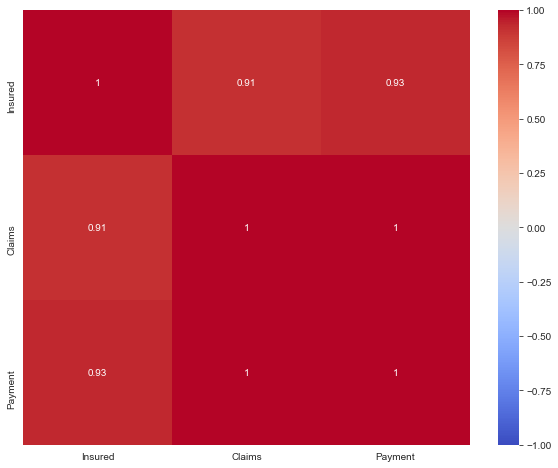

In [35]:
#Heatmap

"""Heatmap for analysis"""

fig,ax = plt.subplots(figsize=(10,8))
sns.heatmap(numerics.corr(),vmin=-1, vmax=1, center=0, cmap='coolwarm', ax=ax,annot=True)
plt.show()

In [36]:
#claims and Insured are highly correlated


motor_insurance.drop('Claims',axis=1,inplace=True)

### Using Tweedie Regression

In [37]:
#train-test split

mask = np.random.rand(len(motor_insurance)) < 0.8
df_train = motor_insurance[mask]
df_test = motor_insurance[~mask]
print('Training data set length='+str(len(df_train)))
print('Testing data set length='+str(len(df_test)))

Training data set length=1438
Testing data set length=359


In [46]:
#expression for GLM regression 

expression = "Payment ~ Kilometres  + Zone+ Bonus+  Make + Insured   "


# Converting data into dmatrices
y_train, X_train = dmatrices(expression, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expression, df_test, return_type='dataframe')

In [55]:
X_train.head(3)

,Intercept,Kilometres[T.2],Kilometres[T.3],Kilometres[T.4],Kilometres[T.5],Zone[T.2],Zone[T.3],Zone[T.4],Zone[T.5],Zone[T.6],...,Bonus[T.7],Make[T.2],Make[T.3],Make[T.4],Make[T.5],Make[T.6],Make[T.7],Make[T.8],Make[T.9],Insured
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69.17
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,72.88
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1292.39


In [47]:
# Training model
tweedie_model = sm.GLM(y_train, X_train, family=sm.families.Tweedie(link=None,var_power=1.9,eql=True))

tweedie_result = tweedie_model.fit()

In [99]:
# tweedie_result_reg = tweedie_model.fit_regularized(method='elastic_net',alpha=0, L1_wt=0.3, start_params=None, refit=True)

In [48]:
print(tweedie_result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                Payment   No. Observations:                 1438
Model:                            GLM   Df Residuals:                     1412
Model Family:                 Tweedie   Df Model:                           25
Link Function:                    log   Scale:                          2.6199
Method:                          IRLS   Log-Likelihood:                -17867.
Date:                Sun, 16 May 2021   Deviance:                       3407.4
Time:                        18:28:50   Pearson chi2:                 3.70e+03
No. Iterations:                    23                                         
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          12.7269      0.115    1

In [ ]:
# print(tweedie_result_reg.summary())
# print('-'*50)
# print(tweedie_result_reg.summary2())
# print('-'*50)
# y_pred_reg = tweedie_result_reg.predict(X_test)
# print('-'*50)
# rmse =np.sqrt(mean_squared_error(y_test,y_pred_reg))
# rmse

In [49]:
print(tweedie_result.summary2())

               Results: Generalized linear model
Model:               GLM              AIC:            35785.6086
Link Function:       log              BIC:            -6859.2489
Dependent Variable:  Payment          Log-Likelihood: -17867.   
Date:                2021-05-16 18:29 LL-Null:        -22791.   
No. Observations:    1438             Deviance:       3407.4    
Df Model:            25               Pearson chi2:   3.70e+03  
Df Residuals:        1412             Scale:          2.6199    
Method:              IRLS                                       
----------------------------------------------------------------
                 Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------
Intercept       12.7269   0.1148 110.8924 0.0000 12.5020 12.9519
Kilometres[T.2]  0.2184   0.0730   2.9908 0.0028  0.0753  0.3615
Kilometres[T.3] -0.2396   0.0748  -3.2010 0.0014 -0.3862 -0.0929
Kilometres[T.4] -1.0493   0.0807 -12.9997

In [165]:
# #estimate the power for tweedie
# mu = tweedie_result.mu
# GLM.estimate_tweedie_power( mu, method='brentq', low=1.01, high=5.0)

In [50]:
#predicting the test set

y_pred = tweedie_result.predict(X_test)

In [51]:
#calculating the RMSE error

rmse =np.sqrt(mean_squared_error(y_test,y_pred))
rmse

1723319.5654440103

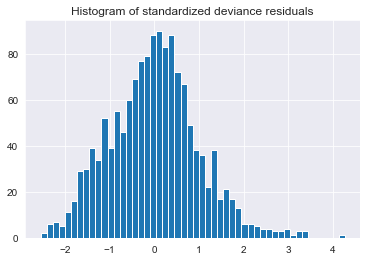

In [52]:
#histogram for errors

fig, ax = plt.subplots()

resid = tweedie_result.resid_deviance.copy()
resid_std = stats.zscore(resid)
ax.hist(resid_std, bins=50)
ax.set_title('Histogram of standardized deviance residuals');

c:\users\harsh\anaconda3\envs\insurance\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


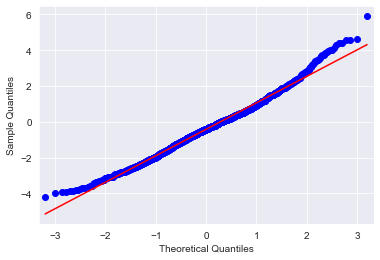

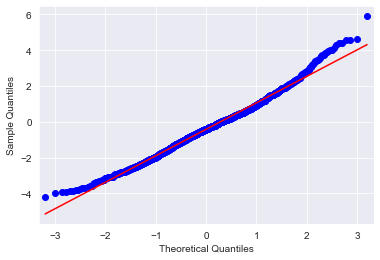

In [53]:
#Q-Q plot for residuals

graphics.gofplots.qqplot(resid, line='r')

In [54]:
#pickle the model

file = open("insurance_prediction.pkl","wb")

pickle.dump(tweedie_result,file)